# **Downloading Dataset**

In [2]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'microsoft-catsvsdogs-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F550917%2F1003830%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240718%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240718T130835Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D8c374a62bbe1d19c8e1cf9ae6082a9e90b27758002c3df75199fed7b3b422d91dc008f831dd83e710337dab1d80dc9c00a603b6a72dcff9cbf27a68d1a8be51b2b8d4e6b06105eb15e8d6a88681bacd92ed113ecd4154d235910bb72f71be6496f788a5c1810fec084a13ff4d6cc01630c10e87b1942cb317bd2fca01df2f1965fb02af1f55884f116e92a5a534fe2d50aa96daa7d28a9ce8fd4616b04aa0be97470de8bed37c9b9ae9f2657f56ae2b206f2ed4157c69577c1a5568238bfc427d57a6254517d3e953e8d3136970316ba67c9c6556f9ee05894271b5986da6c2d7de3cbb34ab86ce33a988721f44b7d2f68b1f840ae30e55687eb751d1dc885a6'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 825979578 bytes downloaded
Downloaded and uncompressed: microsoft-catsvsdogs-dataset
Data source import complete.


# **Importing Necessary Libraries**

In [3]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers


# **Preprocessing**

In [4]:
import os

dog_cnt, cat_cnt = 0,0
# countin dogs images
for items in os.listdir('/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog'):
    dog_cnt+=1
for items in os.listdir('/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Cat'):
    cat_cnt+=1
print(f'there are total {dog_cnt} dog images and {cat_cnt} cat images')

there are total 12501 dog images and 12501 cat images


In [5]:
# record all dogs and cats images
dog_imgs = os.listdir('/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog')
cat_imgs = os.listdir('/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Cat')

In [6]:
# function to create train/test and val folders
import shutil
def creat_folder(start_index,end_index,dir_name):
    # create the folder
    os.mkdir(os.path.join('/kaggle/working/',dir_name)) if not os.path.exists(os.path.join('/kaggle/working/',dir_name)) else print('already exists')
    os.mkdir(os.path.join('/kaggle/working/',dir_name,'Cat')) if not os.path.exists(os.path.join('/kaggle/working/',dir_name,'Cat')) else print('already exists')
    os.mkdir(os.path.join('/kaggle/working/',dir_name,'Dog')) if not os.path.exists(os.path.join('/kaggle/working/',dir_name,'Dog')) else print('already exists')

    # samples images according to start and end indexes
    sample_dog = dog_imgs[start_index:end_index]
    sample_cat = cat_imgs[start_index:end_index]

    # sampling dog imgaes and pasting it to destination folder
    for img in sample_dog:
        if img ==  '666.jpg' or img ==  '11702.jpg':
            continue
        src = os.path.join('/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog',img)
        dst = os.path.join('/kaggle/working/',dir_name,'Dog')
        shutil.copy(src, dst)
    # sampling cat imgaes and pasting it to destination folder
    for img in sample_cat:
        # corrput files
        if img ==  '666.jpg' or img ==  '11702.jpg':
            continue
        src = os.path.join('/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Cat',img)
        dst = os.path.join('/kaggle/working/',dir_name,'Cat')
        shutil.copy(src, dst)

In [7]:
# train data
dir_name = 'train'
creat_folder(0,1000,dir_name)
# test data
dir_name = 'test'
creat_folder(1000,2000,dir_name)
# validation data
dir_name = 'val'
creat_folder(2000,2500,dir_name)

# **Displaying Sample Images**

In [8]:
from google.colab import files

# Upload the image file
uploaded = files.upload()

Saving cat1.jpg to cat1.jpg
Saving dog1.jpg to dog1.jpg


In [9]:
from PIL import Image
import io
import matplotlib.pyplot as plt
# Get the uploaded file path
Cat = list(uploaded.keys())[0]
Dog = list(uploaded.keys())[1]

# Open the image
sample_cat = Image.open(io.BytesIO(uploaded[Cat]))
sample_dog = Image.open(io.BytesIO(uploaded[Dog]))

(300, 280)


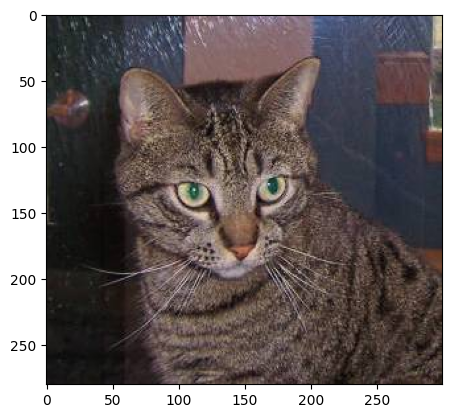

In [10]:
plt.imshow(sample_cat)
print(sample_cat.size)

(640, 635)


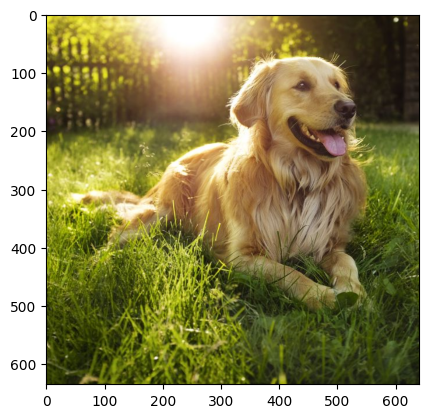

In [11]:
plt.imshow(sample_dog)
print(sample_dog.size)

# **CNN Model building**

In [12]:
inputs = keras.Input(shape=(180,180,3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32,kernel_size=3, activation='relu')(x)
x = layers.MaxPool2D(pool_size=2)(x)
x = layers.Conv2D(filters=64,kernel_size=3, activation='relu')(x)
x = layers.MaxPool2D(pool_size=2)(x)
x = layers.Conv2D(filters=128,kernel_size=3, activation='relu')(x)
x = layers.MaxPool2D(pool_size=2)(x)
x = layers.Conv2D(filters=256,kernel_size=3, activation='relu')(x)
x = layers.MaxPool2D(pool_size=2)(x)
x = layers.Conv2D(filters=256,kernel_size=3, activation='relu')(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid") (x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [13]:
model.compile(loss = 'binary_crossentropy',
              optimizer = 'rmsprop',
              metrics=['accuracy'])

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_data = ImageDataGenerator().flow_from_directory(
    directory='/kaggle/working/train',
    target_size=(180,180),
    batch_size=32,
    class_mode='binary'
)
val_data = ImageDataGenerator().flow_from_directory(
    directory='/kaggle/working/val',
    target_size=(180,180),
    batch_size=32,
    class_mode='binary'
)
test_data = ImageDataGenerator().flow_from_directory(
    directory='/kaggle/working/test',
    target_size=(180,180),
    batch_size=32,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [15]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
    filepath='/kaggle/working/model.keras',
    save_best_only=True,
    monitor="val_loss")
]

In [16]:
history = model.fit(train_data,epochs=20,validation_data=val_data,callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 199s 3s/step - loss: 0.7002 - accuracy: 0.5180 - val_loss: 0.6917 - val_accuracy: 0.5000
Epoch 2/20
63/63 [==============================] - 201s 3s/step - loss: 0.6903 - accuracy: 0.5570 - val_loss: 0.6753 - val_accuracy: 0.5570
Epoch 3/20
63/63 [==============================] - 211s 3s/step - loss: 0.6557 - accuracy: 0.6085 - val_loss: 0.6308 - val_accuracy: 0.6460
Epoch 4/20
63/63 [==============================] - 211s 3s/step - loss: 0.6264 - accuracy: 0.6455 - val_loss: 0.6196 - val_accuracy: 0.6680
Epoch 5/20
63/63 [==============================] - 203s 3s/step - loss: 0.5955 - accuracy: 0.6740 - val_loss: 0.6818 - val_accuracy: 0.5840
Epoch 6/20
63/63 [==============================] - 200s 3s/step - loss: 0.5704 - accuracy: 0.7045 - val_loss: 0.6231 - val_accuracy: 0.6290
Epoch 7/20
63/63 [==============================] - 197s 3s/step - loss: 0.5310 - accuracy: 0.7295 - val_loss: 0.6298 - val_accuracy: 0.7080
Epoch 8/20
63

In [17]:
model.evaluate(test_data)

63/63 [==============================] - 52s 812ms/step - loss: 1.0853 - accuracy: 0.7490


[1.0853215456008911, 0.7490000128746033]

In [18]:
train_acc = history.history["accuracy"]
train_loss = history.history["loss"]
val_acc = history.history["val_accuracy"]
val_loss = history.history["val_loss"]

epochs = range(1,len(train_acc)+1)

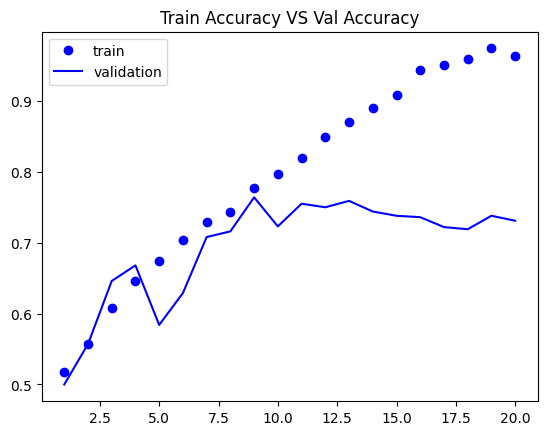

In [19]:
plt.plot(epochs,train_acc,"bo",label='train')
plt.plot(epochs,val_acc,'b',label='validation')
plt.title('Train Accuracy VS Val Accuracy')
plt.legend()
plt.show()

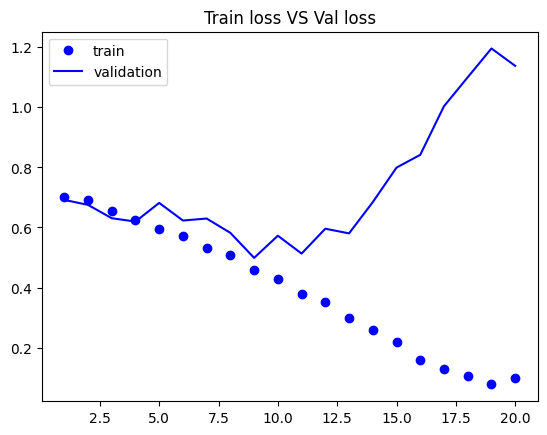

In [20]:
plt.plot(epochs,train_loss,"bo",label='train')
plt.plot(epochs,val_loss,'b',label='validation')
plt.title('Train loss VS Val loss')
plt.legend()
plt.show()